# Projet de *Networks for information retrieval*

In [1]:
!pip install -U sentence-transformers # package pour Sentence Bert
!pip install torch-geometric # package pour GCN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.1/163.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
from google.colab import drive

import pandas as pd
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import accuracy_score

import networkx as nx

from sentence_transformers import SentenceTransformer
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from torch_geometric.data import Data

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Données + Descriptive

#### Télécharger les données

In [4]:
# connecter au google drive. Si vous être en local, pas besoin d'exécuter cette cellule.
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/data_MIASHS.zip -d /content  # vous pouvez changer le lien pour accéder aux données.

Archive:  /content/drive/MyDrive/data_MIASHS.zip
   creating: /content/20240125_dataset_pickle/
  inflating: /content/__MACOSX/._20240125_dataset_pickle  
  inflating: /content/20240125_dataset_pickle/20240125_dataset_rscir_xxs.pickle  
  inflating: /content/__MACOSX/20240125_dataset_pickle/._20240125_dataset_rscir_xxs.pickle  
  inflating: /content/20240125_dataset_pickle/20240125_dataset_emixx_grif.pickle  
  inflating: /content/__MACOSX/20240125_dataset_pickle/._20240125_dataset_emixx_grif.pickle  
  inflating: /content/20240125_dataset_pickle/20240124_dataset_1895_assr.pickle  
  inflating: /content/__MACOSX/20240125_dataset_pickle/._20240124_dataset_1895_assr.pickle  
  inflating: /content/20240125_dataset_pickle/20240125_dataset_ofce_receo.pickle  
  inflating: /content/__MACOSX/20240125_dataset_pickle/._20240125_dataset_ofce_receo.pickle  
  inflating: /content/20240125_dataset_pickle/20240125_dataset_hedu_karst.pickle  
  inflating: /content/__MACOSX/20240125_dataset_pickle/._2

#### Fonctions utiles

In [6]:
def domaine_mapping(indice):
    '''
    Cette fonction récupère le domaine des documents qui se trouve dans l'identifiant et crée ainsi un vecteur des domaines
    Entrée :
      indice : le vecteur des identifiants
    Sortie :
      vecteur des domaines
    '''
    # obtenir l'indice du domaine
    y = [st[len("http://data.persee.fr/doc/"):st.find("_")] for st in indice]
    # traduction au domaine selon le dictionnaire de Persée
    domaines = pd.read_csv("/content/20240125_dataset_pickle/20240141_disciplines.csv", sep = ";")
    return [domaines[domaines.collection_id == yy].Discipline.values[0] if len(domaines[domaines.collection_id == yy]) > 0 else np.nan for yy in y]


#### Prétraiter les données

In [7]:
# liste vide pour stocker les dataframes
df_list = []
directory = "/content/20240125_dataset_pickle"

# itérer sur tous les fichiers du repertoire 'directory'
for filename in os.listdir(directory):
    # vérifier si c'est un fichier pickle
    if filename.endswith('.pickle'):
        # chemin complet vers les fichiers
        filepath = os.path.join(directory, filename)
        # convertir le fichier pickle en dataframe
        df = pd.read_pickle(filepath)
        # ajouter le dataframe (identifier, titre, abstracte) dans la liste de datraframes
        df = df[["dcterms:identifier{Literal}","dcterms:title{Literal}","dcterms:abstract{Literal}@fr"]]
        df_list.append(df)

# concaténer les dataframes
data = pd.concat(df_list, ignore_index=True)
# nombre total de documents dans le corpus : 908780
n_complet = len(data)

# enlever les nan values (parce que toutes les colonnes dans le dataframe sont nécessaires pour l'analyse)
data = data.dropna()
# nombre de documents qui ont un abstract : 99888
n_abstract = len(data)

# obtenir les domaines et les encoder en valeur numérique
domaines = domaine_mapping(data["dcterms:identifier{Literal}"].values)
label_encoder = LabelEncoder()
y_label = label_encoder.fit_transform(domaines).astype(float)

# garder uniquement les documents dont le domaine comprend plus de 4000 documents
# il reste 10 domaine après ce traitement
unique_values, counts = np.unique(y_label, return_counts=True)
values_to_nan = unique_values[counts < 4000]
y_label[np.where(np.isin(y_label, values_to_nan))[0]] = np.nan
data["label"] = y_label
data = data.dropna()
data.index = np.arange(0,len(data))

#### Visualiser la distribution des documents par domaine

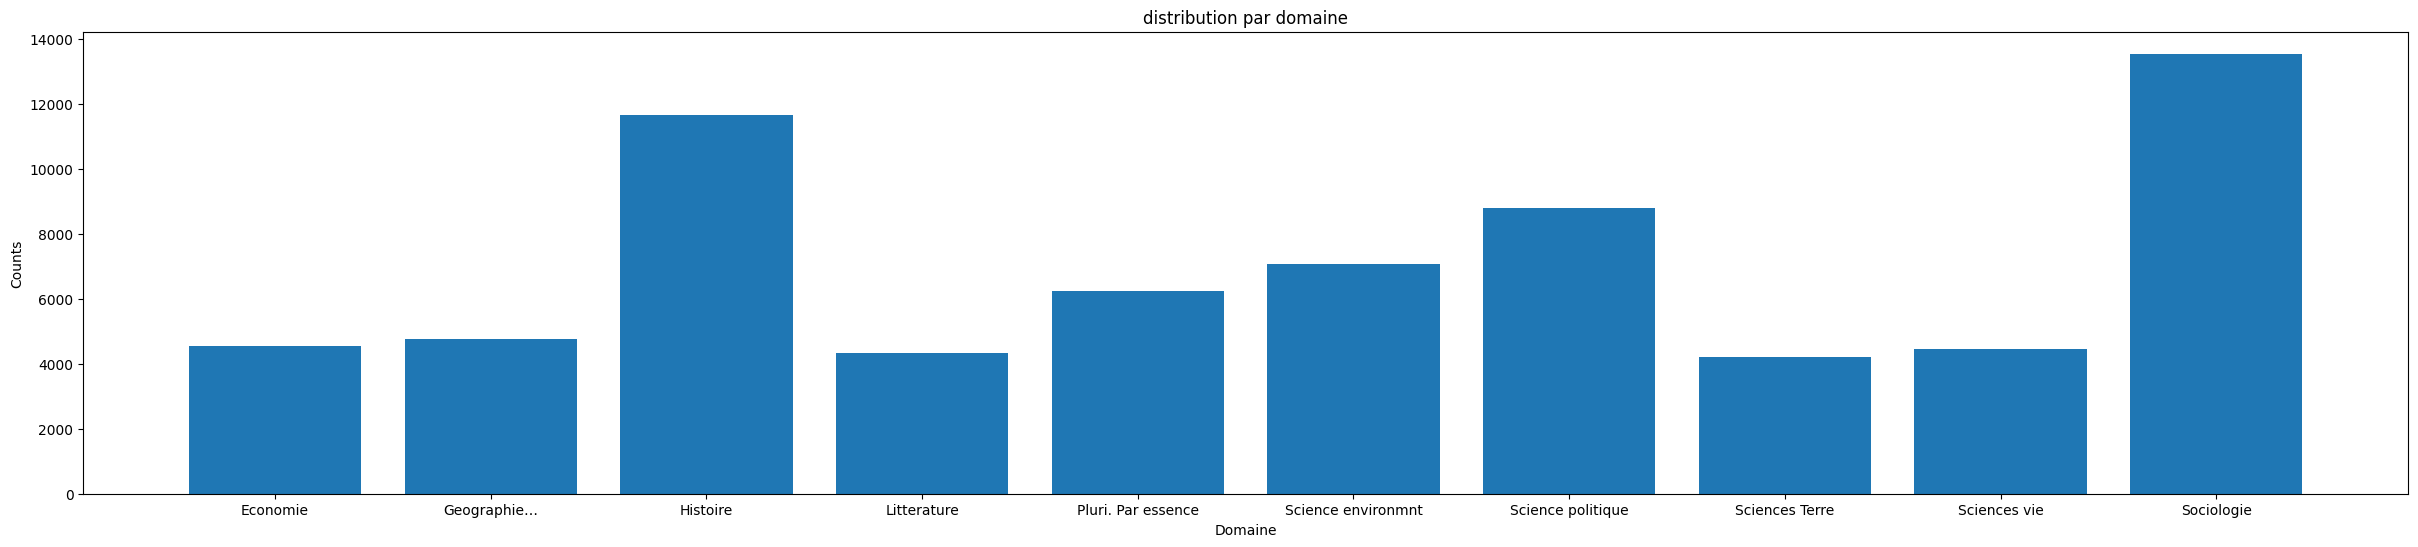

In [8]:
# Obtenir les domaines gardés et leur fréquences
unique_values, counts = np.unique(y_label, return_counts=True)
unique_values = label_encoder.inverse_transform(unique_values[:-1].astype(int))

# Visulisation par bar plot
plt.figure(figsize=(30, 6))
plt.bar(unique_values, counts[:-1])
plt.xlabel('Domaine')
plt.ylabel('Counts')
plt.title('distribution par domaine')
plt.show()

#### Garder un échantillon de taille petite pour l'analyse du graphe

In [9]:
# prendre 1% des données (stratifié selon domaine)
X, _, y, _ = train_test_split(data[["dcterms:title{Literal}","dcterms:abstract{Literal}@fr"]], data['label'], stratify = data["label"], test_size=0.99, random_state=42)

# taille d'échantillon pour l'analyse N=696
N = len(X)

# remettre l'index en (0, 1, ... ,696)
X.index = np.arange(0,N)

# remettre les labels en (0, 1, ... ,10) par la transformation par un dictionnaire
transformed_dict = {value: index for index, value in enumerate(sorted(set(y)))} # créer le dictionnaire
y = np.array([transformed_dict[value] for value in y.values]) # transformation

## Graphe

#### Définir les fonction utiles

In [10]:
def compute_adjacency_matrix(matrix, threshold=0.5):
    '''
    Cette fonction calcule une matrice d'adjacence en utilisant la similarité cosinus

    Entrée :
      matrix : matrice de représentation vectorielle
      threshold : seuil pour la similarité cosinus pour créer une arrête
    Sortie :
      adjacency_matrix : la matrice d'adjacence
    '''
    normalized_matrix = matrix / torch.norm(matrix, dim=1, keepdim=True)
    cosine_similarities = torch.matmul(normalized_matrix, normalized_matrix.t())

    cosine_similarities.fill_diagonal_(0) # digonale 0
    adjacency_matrix = torch.where(cosine_similarities > threshold, torch.tensor(1.0), torch.tensor(0.0))
    return adjacency_matrix

def graphe_visualisation(G, y):
    '''
    Cette fonction visulise le plus grand composant connexe d'un graphe (les autres composant connexes ont juste un ou deux noueds)
    Elle permet de mettre les couleurs aux noeuds selon un vecteur label
    Entrée :
      G : le graphe
      y : le vecteur label
    '''
    # trouver le plus grand composant connexe
    largest_component = max(nx.connected_components(G), key=len)
    G_large = G.subgraph(largest_component)

    # trouver les domaines
    labels = label_encoder.inverse_transform(y.astype(int))
    labels_large = labels[list(largest_component)]

    # mettre un couleur pour chanque domaine
    color_map = {label: f'C{i}' for i, label in enumerate(set(labels_large))}

    # visualiser le graphe
    plt.figure(figsize=(15, 15))
    nx.draw(G_large, pos = nx.spring_layout(G_large), with_labels=False, node_size=50, node_color=[color_map[label] for label in labels_large])
    plt.title("Graphe")

    # ajouter les légende
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Label {label}') for label, color in color_map.items()]
    plt.legend(handles=legend_handles, title='Labels', loc='upper left')

    plt.show()

#### Créer le graphe et le visualiser

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.69k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

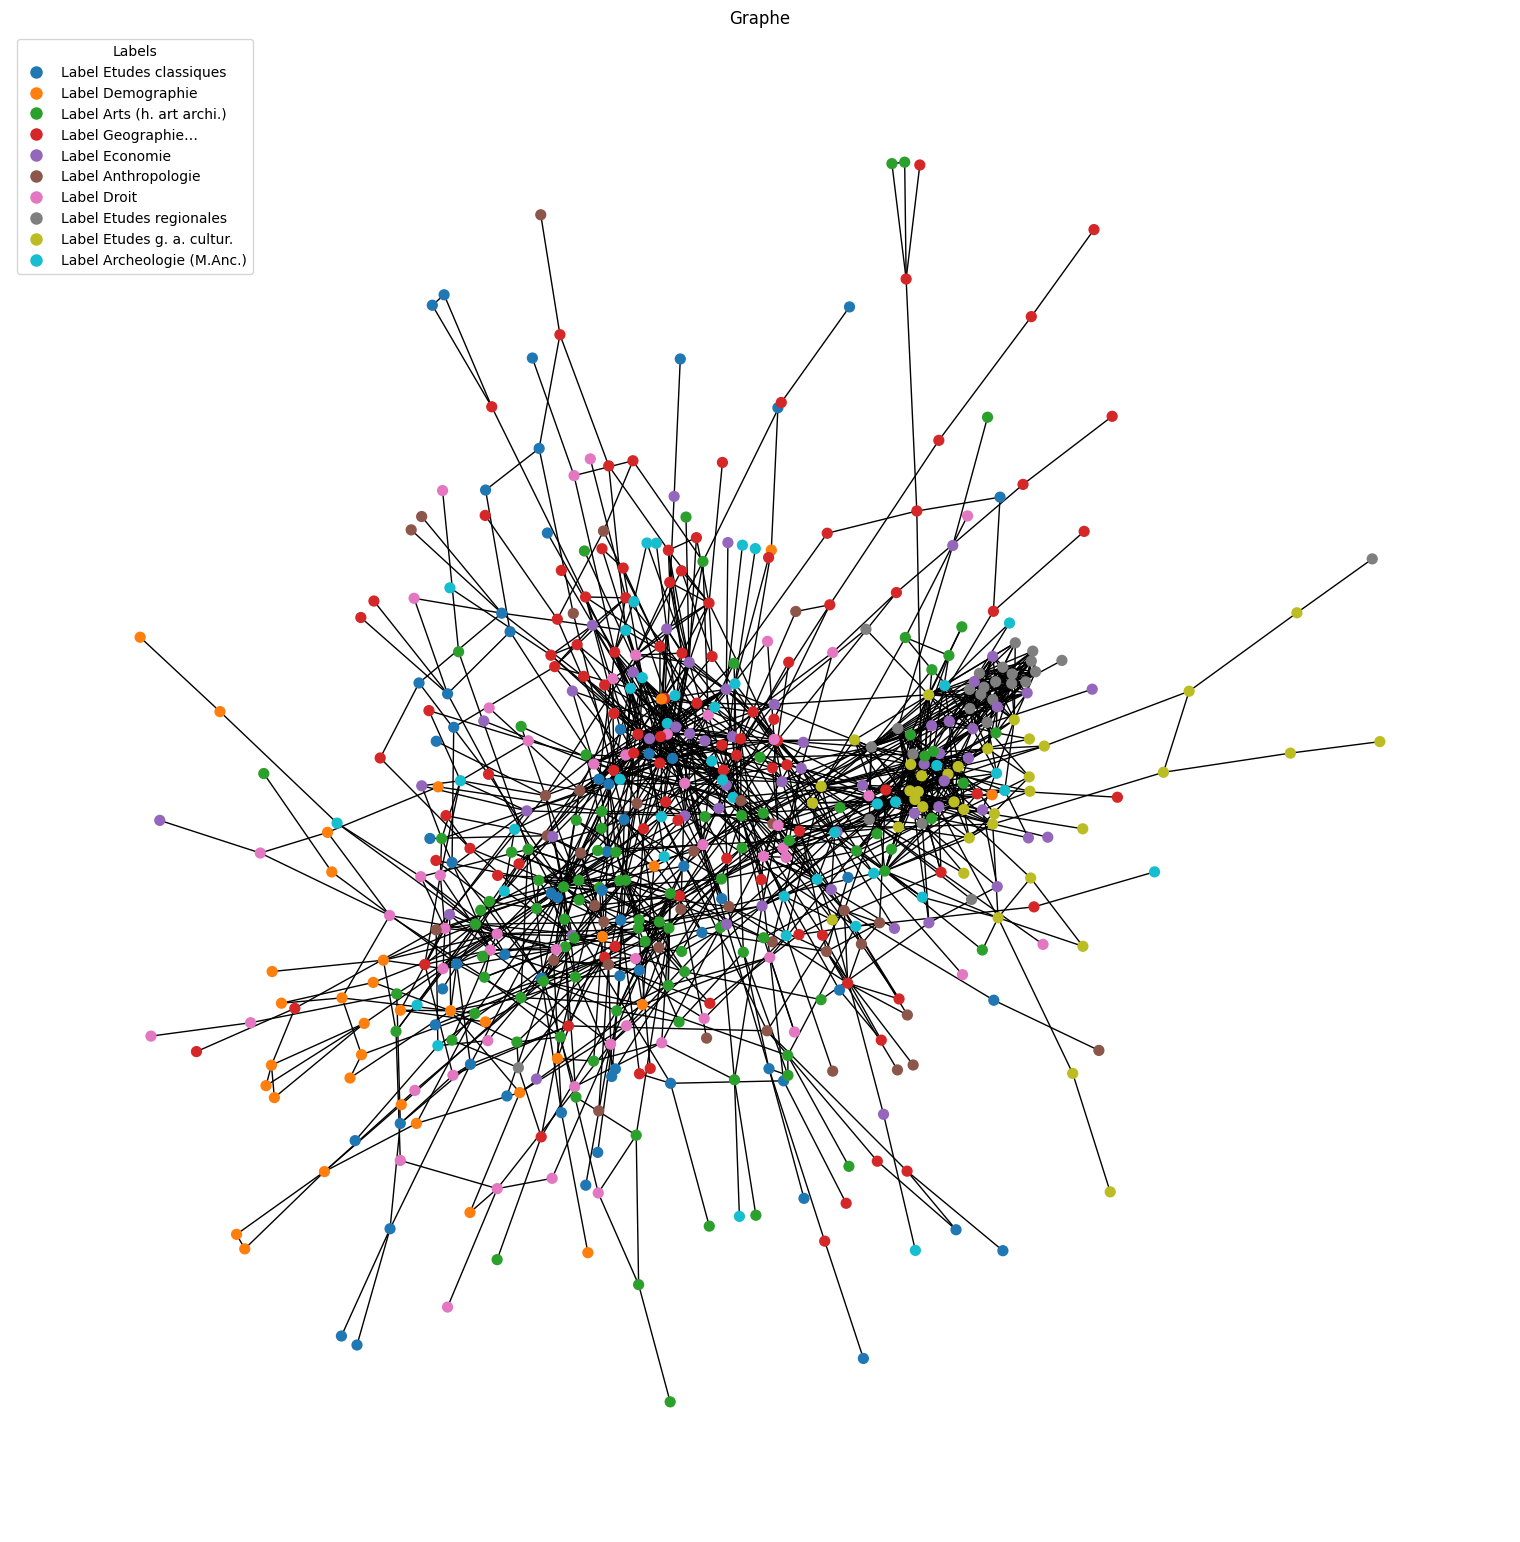

In [11]:
# concaténer titre et abstract
text_data = X["dcterms:title{Literal}"] + " " + X["dcterms:abstract{Literal}@fr"]

# Calculer la taille moyenne des textes : 985
text_lengths = [len(text) for text in text_data]
average_length = sum(text_lengths) / len(text_lengths)

# transformer en vecteur sémantique par sentence bert
s_bert = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2').to(device)
embeddings = s_bert.encode(text_data, device = device)

# calculer la matrice d'adjacence
adj_matrix = compute_adjacency_matrix(torch.from_numpy(embeddings).to(device), threshold=0.4)

# créer un graphe à partir de la matrice d'adjacence
G = nx.Graph(adj_matrix.cpu().numpy())

# visualiser le plus grand composant connexe d'un graphe (les autres composant connexes ont juste un ou deux noueds)
graphe_visualisation(G, y)

#### Statistiques du graphe

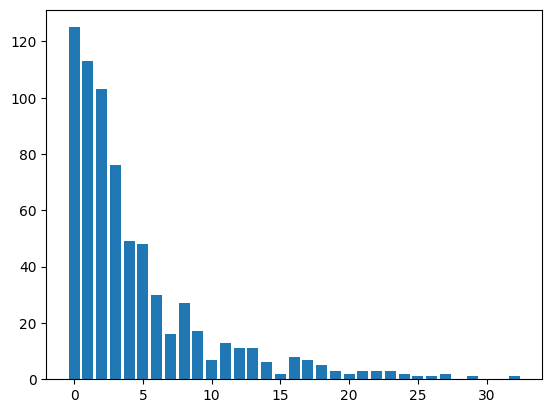

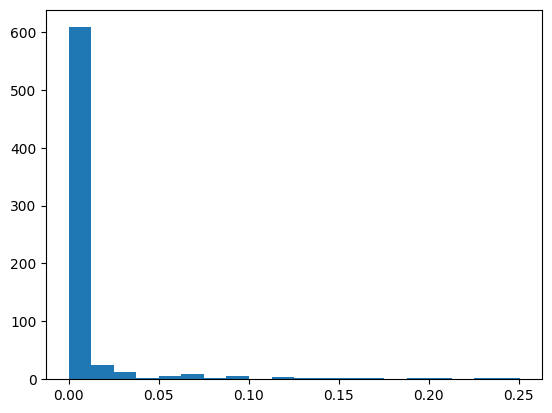

In [12]:
# densité du graphe : 0.0075
density = nx.density(G)

# trouver le plus grand composant connexe
largest_component = max(nx.connected_components(G), key=len)
G_large = G.subgraph(largest_component)

# le nombre de composants connexes : 140
num_connected_components = nx.number_connected_components(G)

# taille du plus grand composant connexe : 536 sur 696 noeuds
n_G_lagre = len(G_large.nodes())

# dimamètre du plus grand composant connexe : 14
diameter = nx.diameter(G_large)

# la distribution des degrées
degree_distribution = [val for (node, val) in G.degree()]
unique_values, counts = np.unique(degree_distribution, return_counts=True)
plt.bar(unique_values, counts)
plt.show()

# la centralité par eignevector (page rank centrality)
# ! peut ne pas converger
eigenvector_centrality = nx.eigenvector_centrality(G_large)
eigenvector_centrality = nx.eigenvector_centrality(G)
plt.hist(eigenvector_centrality.values(),bins=20)
plt.show()

## Moteur de recherche

#### Définir les fonctions utiles

In [13]:
def Moteur_de_recherche_semantique(vector1, matrix, threshold=0, k=5):
    '''
    Cette fonction calcule la similarité cosinus des vecteurs vis-à-vis d'un nouveau vecteur
    et renvoie les 5 les plus similaires (sous condition que la la similarité cosinus soit supérieur à 0)
    Entrée :
      vector1 : nouveau vecteur
      matrix : l'ensemble des vecteurs
      threshold : la seuil, par défaut 0
      k : les k premiers plus proches, par défaut 5
    Sortie :
      les indices des k premiers plus proches
    '''

    # calculer la similarité cosinus
    normalized_vector1 = vector1 / torch.norm(vector1)
    normalized_matrix = matrix / torch.norm(matrix, dim=1, keepdim=True)
    similarity_scores = torch.matmul(normalized_matrix, normalized_vector1)

    # garder les indices des vecteurs selon le seuil
    similar_indices = torch.nonzero(similarity_scores > threshold, as_tuple=False).squeeze(1)

    # trier selon la similarité cosinus
    sorted_indices = similar_indices[similarity_scores[similar_indices].argsort(descending=True)]

    # renvoyer les indices des k premiers (si il y a moins de k éléments, renvoyer tous les indices)
    if len(sorted_indices) < k :
      return sorted_indices
    else :
      return sorted_indices[:k]

def Moteur_de_recherche_structurel(vector1, matrix, adj_matrix, k=5):
    '''
    Cette fonction calcule la similarité cosinus des vecteurs vis-à-vis d'un nouveau vecteur
    et renvoie l'indice du vecteur le plus similaire ainsi que ces 5 voisins selon une matrice d'adjacence
    Entrée :
      vector1 : nouveau vecteur
      matrix : l'ensemble des vecteurs
      adj_matrix : la matrice d'adacence qui contient l'information structurelle de l'ensemble des vecteurs
      k : le nombre de voisin à garder, par défault 5
    Sortie :
      les indices des vecteurs gardés
    '''

    # calculer la similarité cosinus
    normalized_vector1 = vector1 / torch.norm(vector1)
    normalized_matrix = matrix / torch.norm(matrix, dim=1, keepdim=True)
    similarity_scores = torch.matmul(normalized_matrix, normalized_vector1)

    # trouver l'indice du vecteur le plus similaire
    max_index = torch.argmax(similarity_scores)

    # trouver les indices des voisin du vecteur le plus similaire
    neighbor_indices = torch.nonzero(adj_matrix[max_index] == 1, as_tuple=False).squeeze(1)
    neighbor_indices = neighbor_indices[:k] if len(neighbor_indices) >= k else neighbor_indices

    # renvoyer tous les indices
    indices = torch.cat((torch.unsqueeze(max_index, dim=0), neighbor_indices))
    return indices

#### la solution sémantique

In [14]:
# petite interaction avec l'utilisateur ...
# Entree = input("Que voulez-vous chercher ? : ")

# transformer la saisie par sentence bert
Entree = "Immigration en Europe"
Entree_embed = s_bert.encode(Entree, device = device)

# trouver les indices des réponses proposées
similar_indices = Moteur_de_recherche_semantique(torch.from_numpy(Entree_embed).to(device), torch.from_numpy(embeddings).to(device), threshold=0, k=5)

# afficher les réponses
for i in similar_indices.cpu().numpy():
  print(text_data[i])
  print()

Le droit européen des migrations : exemple d’un droit en mouvement ?  Un véritable droit européen des migrations comportant des règles de droit matériel de plus en plus précises se construit, lentement mais sûrement. comme le droit international des migrations, il laisse une place importante à différentes enceintes informelles élaborant ce qu’il est convenu d’appeler du droit assourdi (soft law). Toutefois, à la différence du cadre international, dans le cadre européen, l’élaboration de ces normes est de plus en plus formalisée et prolongée par un contrôle juridictionnel commun de nature à sauvegarder une plus juste balance des intérêts en présence : les souverainetés et les droits fondamentaux. encore faut-il que d’une part l’Europe, comme le nord Global en général, associe mieux les pays d’origine des migrants à l’élaboration d’une politique de gestion plus que de répression et que d’autre part, le contrôle juridictionnel soit également efficace au sein des ordres juridiques nationau

#### la solution structurelle

In [15]:
indices = Moteur_de_recherche_structurel(torch.from_numpy(Entree_embed).to(device), torch.from_numpy(embeddings).to(device), adj_matrix, k=5)
for i in indices.cpu().numpy():
  print(text_data[i])
  print()

Le droit européen des migrations : exemple d’un droit en mouvement ?  Un véritable droit européen des migrations comportant des règles de droit matériel de plus en plus précises se construit, lentement mais sûrement. comme le droit international des migrations, il laisse une place importante à différentes enceintes informelles élaborant ce qu’il est convenu d’appeler du droit assourdi (soft law). Toutefois, à la différence du cadre international, dans le cadre européen, l’élaboration de ces normes est de plus en plus formalisée et prolongée par un contrôle juridictionnel commun de nature à sauvegarder une plus juste balance des intérêts en présence : les souverainetés et les droits fondamentaux. encore faut-il que d’une part l’Europe, comme le nord Global en général, associe mieux les pays d’origine des migrants à l’élaboration d’une politique de gestion plus que de répression et que d’autre part, le contrôle juridictionnel soit également efficace au sein des ordres juridiques nationau

## Clustering

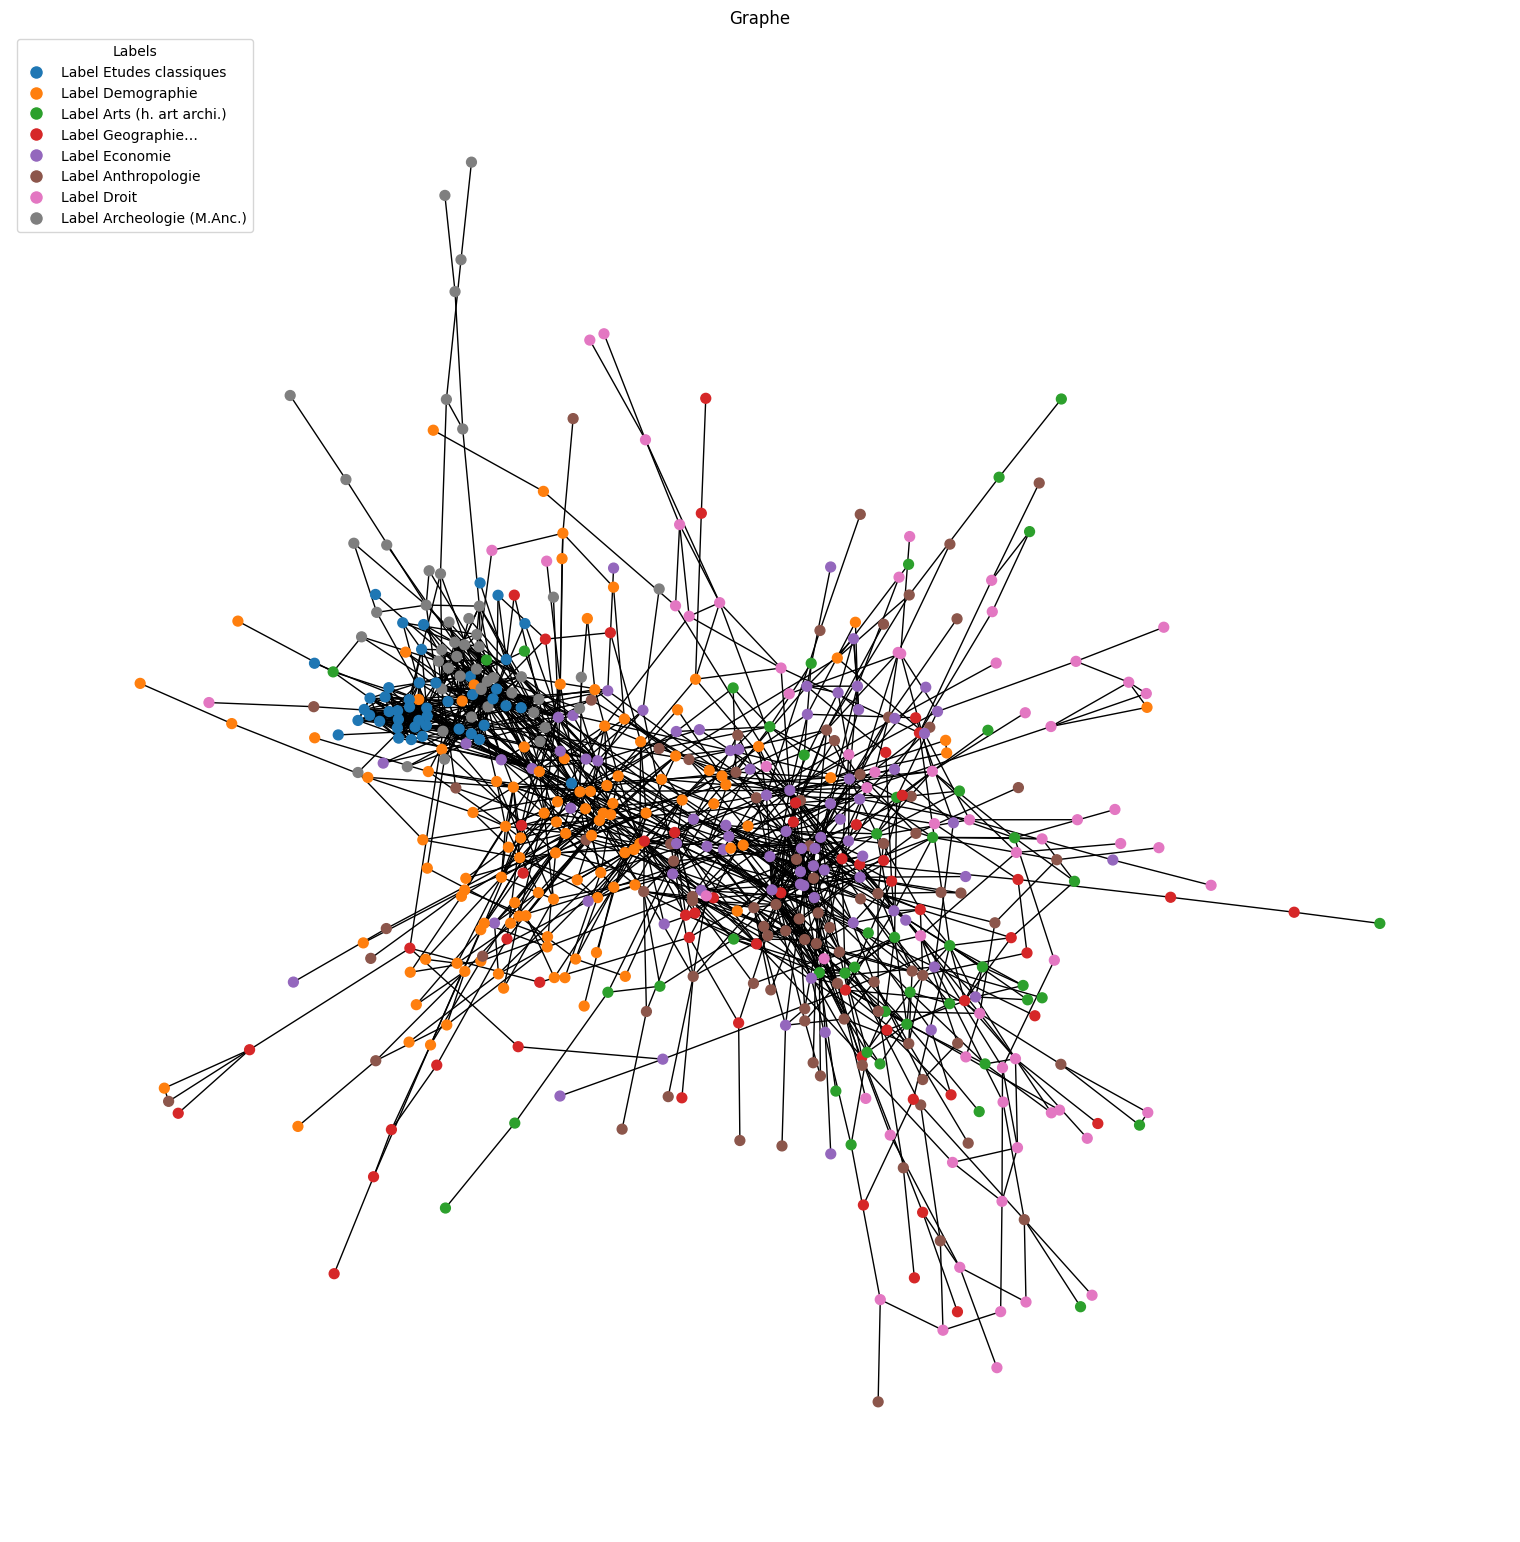

In [16]:
# Effectuer le clustering spectral avec la similarité cosinus
spectral_clustering = SpectralClustering(n_clusters=10, affinity='cosine', random_state=0)
clusters = spectral_clustering.fit_predict(embeddings)

# calculer ARI score avec les vrais labels : 0.1175
ari_score = adjusted_rand_score(y, clusters)

# visuliser le graphe et mettre des couleurs aux noeuds selon les clusters trouvés
graphe_visualisation(G, clusters)

## Classification

#### Créer les modèles à tester

In [17]:
# réseau de neuronne à deux couches linéaires
class NNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# GCN à deux couche + une couche linéaire
class GCN(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()
        self.conv1 = GCNConv(n_features, 128)
        self.conv2 = GCNConv(128, 64)
        self.fc = nn.Linear(64, num_classes)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

#### Préparation des données

In [18]:
# Séparer les données de manière stratifiée en jeu d'entrainement et jeu de test (20%)
indices_data = np.arange(len(y))
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(embeddings, y, indices_data, test_size=0.2, random_state=42, stratify = y)

X_train = torch.from_numpy(X_train).to(device)
X_test = torch.from_numpy(X_test).to(device)
y_train = torch.from_numpy(y_train).to(device)
y_test = torch.from_numpy(y_test).to(device)
y_tensor = torch.from_numpy(y).to(device)

# dimension des données
d = len(embeddings[0])

# nombre de classes
num_classes = len(set(y))

### Entrainer et tester le modèle simple

In [19]:
# Hyperparametres
input_size = d
hidden_size = d
num_epoch = 500

# Initialiser
nn_model = NNModel(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001, weight_decay=5e-3) # adam avec régularisation l2

# Entraîner
for epoch in range(num_epoch):
    optimizer.zero_grad()
    outputs = nn_model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

# Evaluation
nn_model.eval()
with torch.no_grad():
    outputs = nn_model(X_test)
    _, predicted = torch.max(outputs, 1)
    test_accuracy = accuracy_score(y_test.cpu().numpy(), predicted.cpu().numpy())
print("Test Accuracy:", test_accuracy)

with torch.no_grad():
    outputs = nn_model(X_train)
    _, predicted = torch.max(outputs, 1)
    train_accuracy = accuracy_score(y_train.cpu().numpy(), predicted.cpu().numpy())
print("Train Accuracy:", train_accuracy)

Test Accuracy: 0.4785714285714286
Train Accuracy: 0.9334532374100719


#### Entraîner et tester GCN

In [20]:
# créer un torch_geometric.data:Data pour GCN
x = torch.from_numpy(embeddings).to(device)
edge_index = torch.tensor(list(G.edges()),dtype=torch.long).to(device)
g_data = Data(x=x, edge_index=edge_index.t().contiguous()).to(device)

# Initialiser
gcn_model = GCN(d,num_classes).to(device)
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.001, weight_decay=5e-3) # adam avec régularisation l2
num_epoch = 1000

# Entraîner
gcn_model.train()
lossl = np.empty(num_epoch)
for epoch in range(num_epoch):
    optimizer.zero_grad()
    out = gcn_model(g_data)
    loss = F.nll_loss(out[indices_train], y_tensor[indices_train])
    loss.backward()
    optimizer.step()

# Evaluation
gcn_model.eval()
pred = gcn_model(g_data).argmax(dim=1)
correct = (pred[indices_test] == y_tensor[indices_test]).sum()
test_acc = int(correct) / len(y_test)
print(f'Test Accuracy: {test_acc:.4f}')

pred = gcn_model(g_data).argmax(dim=1)
correct = (pred[indices_train] == y_tensor[indices_train]).sum()
train_acc = int(correct) / len(y_train)
print(f'Train Accuracy: {train_acc:.4f}')

Test Accuracy: 0.4286
Train Accuracy: 0.8309


#### Tentative d'améliorer le GCN selon les statistique du graphe

In [21]:
# Créer un nouveau graphe
G2 = G # copier le graphe
# Parcourir toutes les arêtes et stocker les noeuds ayant plus de 10 arêtes
nodes_to_remove = [node for node, degree in dict(G2.degree()).items() if degree > 10]
# Enlever les arêtes connectées à ces nœuds
G2.remove_edges_from([(u, v) for u, v in G2.edges() if u in nodes_to_remove or v in nodes_to_remove])

# créer un torch_geometric.data:Data pour GCN
edge_index = torch.tensor(list(G2.edges()),dtype=torch.long).to(device)
g_data = Data(x=x, edge_index=edge_index.t().contiguous()).to(device)

# Initialiser
gcn_model = GCN(d,num_classes).to(device)
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.001, weight_decay=5e-3) # adam avec régularisation l2
num_epoch = 1000

# Entraîner
gcn_model.train()
lossl = np.empty(num_epoch)
for epoch in range(num_epoch):
    optimizer.zero_grad()
    out = gcn_model(g_data)
    loss = F.nll_loss(out[indices_train], y_tensor[indices_train])
    loss.backward()
    optimizer.step()

# Evaluation
gcn_model.eval()
pred = gcn_model(g_data).argmax(dim=1)
correct = (pred[indices_test] == y_tensor[indices_test]).sum()
test_acc = int(correct) / len(y_test)
print(f'Test Accuracy: {test_acc:.4f}')

pred = gcn_model(g_data).argmax(dim=1)
correct = (pred[indices_train] == y_tensor[indices_train]).sum()
train_acc = int(correct) / len(y_train)
print(f'Train Accuracy: {train_acc:.4f}')

Test Accuracy: 0.4000
Train Accuracy: 0.9029
